# Predicting Forest Fires Area in Portugual

<br>

In this project we aim to create models that can predict the area(in ha) burned in fires. We will be working with data from the UCI machine learning [repository](http://archive.ics.uci.edu/ml/datasets/Forest+Fires) and is a collection curated by scientists Paulo Cortez and Anibal Morais from the Unviersity of Minho, Portugal. 

The data includes meteorological measurements taken at the time the fire was reported, `spatial/temporal measurements, and index metrics` that take into a account weather data in the recent past. The index metrics are a part of the **Canadian Fire Weather Index System (FWI)**. The data was collected from January 2000 to December 2003 from the northeast region of Portugal. Data was collected from a total of 517 fires.

Many different ML models can be applied - in the basis [paper](http://archive.ics.uci.edu/ml/datasets/Forest+Fires) the one who achieved the best performance was Support Vector Machines (SVM) although Random Forest also achieved a good performance. We will compare our findings in the end with the ones achieved from Paulo Cortez and Anibal Morais.<br>


## Data Exploration
<br>

Our first step will be to explore the variables and perform data manipulation techniques, if necessary, in order to prepare the dataset for secondary steps such as applying Machine Learning methods. We will check aspects such as the statistical distribution of the variables and how are they correlated to each other (if they are). 

Firstly, lets import the librarys used in this project and load the dataset. 
In sequence the features will be described with details that were provided by the source of the dataset.

<br>

#### Import libraries

In [74]:
# install.packages("e1071")
# install.packages('leaps')
library(ggplot2)
library(GGally)
library(MASS)
library(data.table)
library(grid)
library(gridExtra)
library(lattice)
library(dplyr)
library(PerformanceAnalytics)
library(caret)
library("e1071")
library(leaps)

#### Load the Data 

In [75]:
df_fires <- read.csv(file="forestfires.csv", header=TRUE, sep=",")

In [76]:
head(df_fires) # Dysplay first six rows of the table 

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
,<int>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
2,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
3,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0
6,8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0


### Attribute information:


**1. Spatial information**
   - `X`:      x-axis spatial coordinate within the Montesinho park map: 1 to 9
   -  `Y`:     y-axis spatial coordinate within the Montesinho park map: 2 to 9
   
**2. Temporal information**
   - `month`:  month of the year: "jan" to "dec" 
   - `day`:    day of the week: "mon" to "sun"
   
**3. FWI: The forest Fire Weather Index (FWI). Which is the Canadian system for rating fire danger.**
   - `FFMC`:   FFMC index from the FWI system: 18.7 to 96.20
   - `DMC`:    DMC index from the FWI system: 1.1 to 291.3 
   - `DC`:     DC index from the FWI system: 7.9 to 860.6 
   - `ISI`:    ISI index from the FWI system: 0.0 to 56.10
   
**4. Methorological information**
   - `temp`:   temperature in Celsius degrees: 2.2 to 33.30
   - `RH`:     relative humidity in %: 15.0 to 100
   - `wind`:   wind speed in km/h: 0.40 to 9.40 
   - `rain`:   outside rain in mm/m2 : 0.0 to 6.4 
   
**5. area**:   the burned area of the forest (in ha): 0.00 to 1090.84 


------------------------------------------------------------------------------------------------------------------------

###  Understanding the burned area distribution 
As previously stated we aim to predict the area of the fire according to the other variables. it is logical that we start our data exploration from the area. A first look at the table above show that the area is 0 in all of the first rows which is a concern. The authors in their *paper* have explained that an area smaller than $100m^2$ is replaced by 0. Lets check the distribution using an histogram.

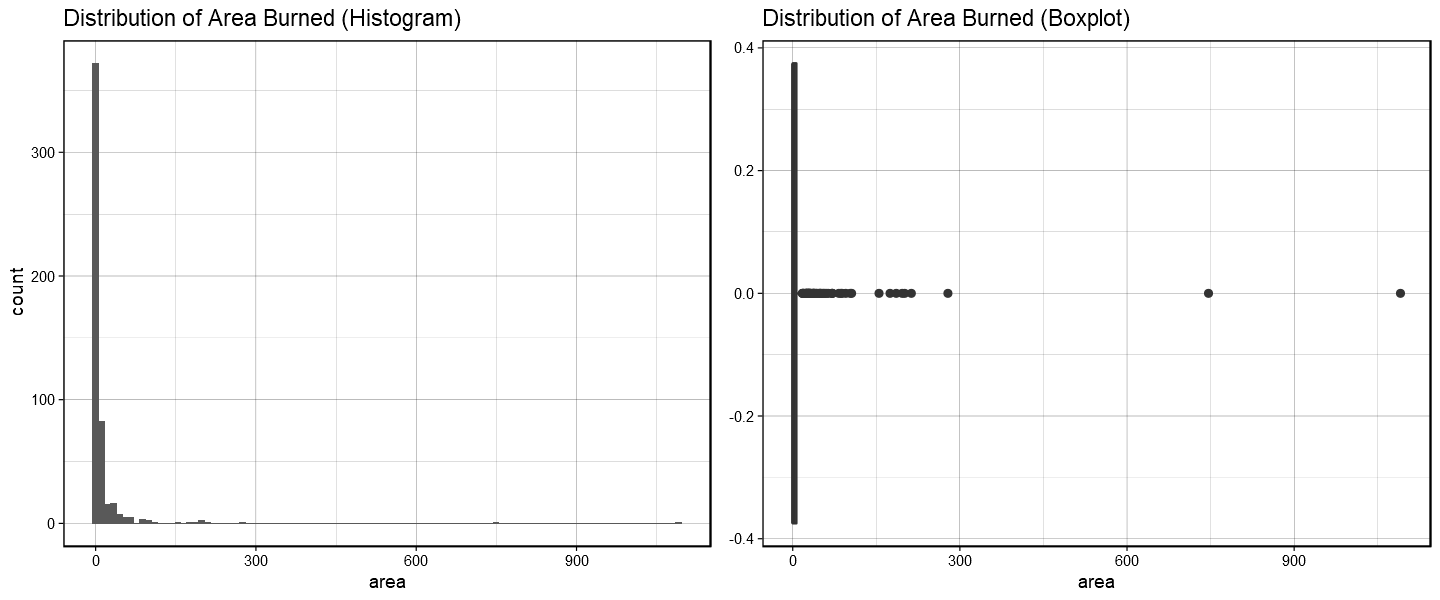

In [77]:
options(repr.plot.width=12, repr.plot.height=5) # area of display

plot1 <- ggplot(df_fires, aes(area)) + geom_histogram(bins = 100) + 
theme_linedraw() + 
ggtitle("Distribution of Area Burned (Histogram)")

plot2 <- ggplot(df_fires, aes(area)) + geom_boxplot() + 
theme_linedraw()+ 
ggtitle("Distribution of Area Burned (Boxplot)")


grid.arrange(plot1, plot2, nrow = 1) # display of first plot

This is an extremely skewed variable and most likely to make a prediction we will have to handle it accordingly. We plan to do a regression in the future and this might be a problem, because for the residuals to be normal the dependent variable cannot have a extremely skewed distribution (as this one). A possible first strategy is to apply the `logarithm` and see how the data will reshape. Important: As we saw many of the data points of area are equal to 0 - so we cannot pass the pure log, but instead we will apply the formula $y = (log_{10}x+1)$

#### Log transformation on the area

In [78]:
df_fires$logarea <- log(df_fires$area+1)

Lets check the effect on the distribution of the area.

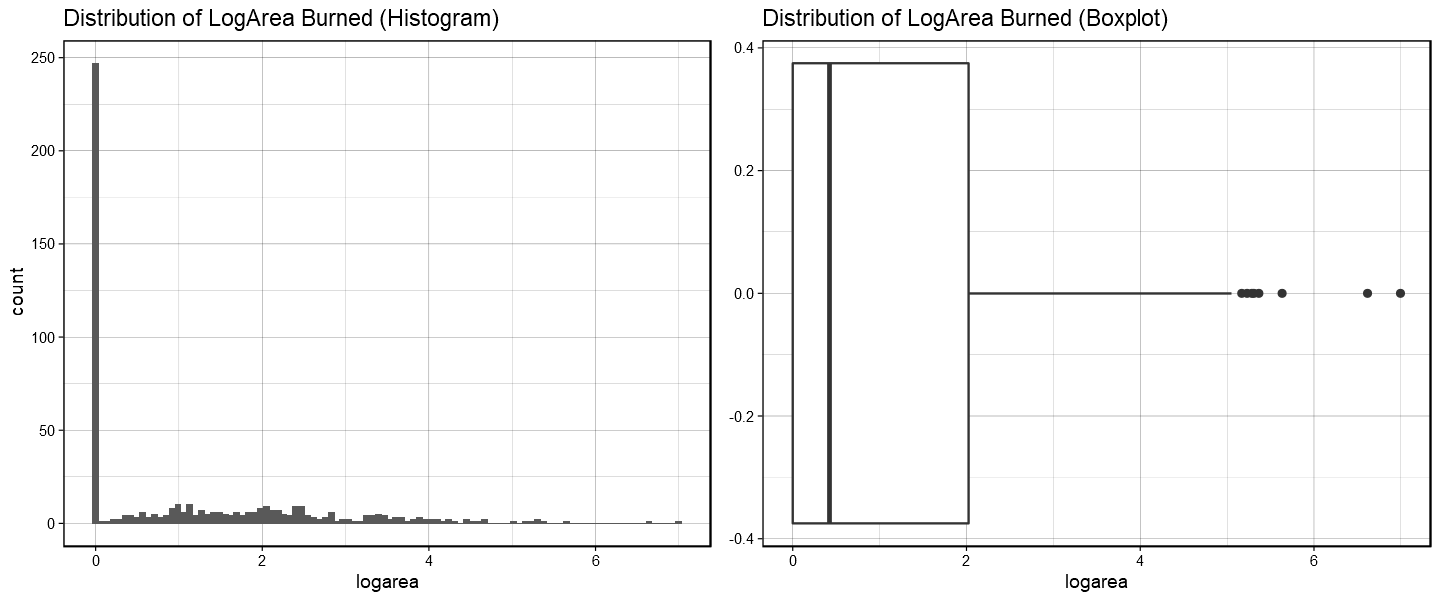

In [79]:
plot3 <- ggplot(df_fires, aes(logarea)) + geom_histogram(bins = 100) + 
theme_linedraw() + 
ggtitle("Distribution of LogArea Burned (Histogram)")

plot4 <- ggplot(df_fires, aes(logarea)) + geom_boxplot() + 
theme_linedraw()+ 
ggtitle("Distribution of LogArea Burned (Boxplot)")

grid.arrange(plot3, plot4, nrow = 1) # display of first plot

Our data remains skilled, however, can see improve in the distribution of the data. We will make a final analysis, by checking what happens if we do not consider the very small fires (size 0). 

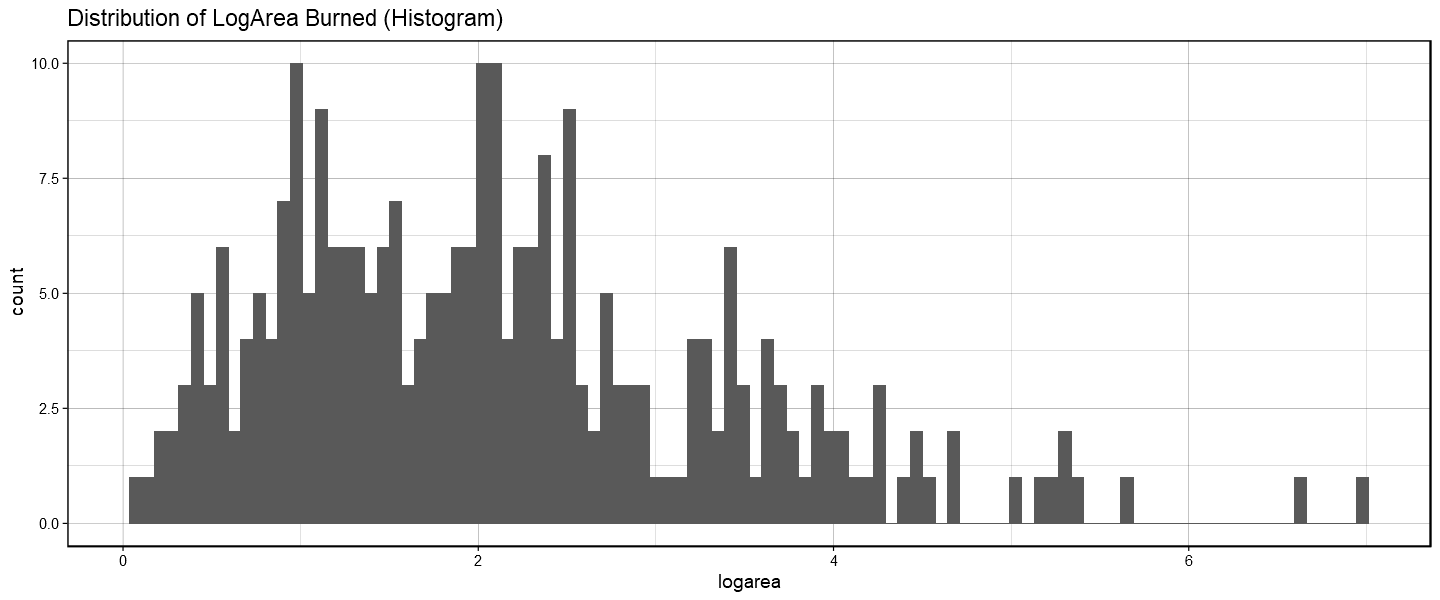

In [80]:
ggplot(df_fires[df_fires$logarea!= 0,], aes(logarea)) + geom_histogram(bins = 100) + 
theme_linedraw() + ggtitle("Distribution of LogArea Burned (Histogram)")

We have found a good distribution to work with, however, we still have to consider the small fires in our analysis. 

### Spatial Analysis
The dataset contains spatial information representing the fires location. The X and Y variables represent the geographical locations in a map and can only be analysed together to make sense. The X axis ranges from 1 to 9 (integers) while the y axis from 2 to 9. Together, they form an area of 72 spaces. We will develop heatmaps in the folowing to identify areas that have been particular areas of focus of fires with respect to:
- The area affected.
- The number of fires.
- Other variables that we might want to compare

In [81]:
# create a table 
df_spatial <- df_fires %>%
  group_by(X,Y) %>%
  summarize(Total_Area = sum(area, na.rm = TRUE),
            Count_Fires  = n(), 
            temp = median(temp, na.rm = TRUE),
            RH = median(RH, na.rm = TRUE),
            wind = median(wind, na.rm = TRUE),
            rain = median(rain, na.rm = TRUE),
            FFMC = median(FFMC, na.rm = TRUE),
            DMC = median(DMC, na.rm = TRUE),
            DC = median(DC, na.rm = TRUE),
            ISI = median(ISI, na.rm = TRUE)
           )

We want to develop a very specific heatmap, with many different features. To simplify the process of plotting we will create a function that will be used to make applied to make different plots.

In [82]:
areaheatplot <- function(scale, tittle) 

{
    Total.heatmap <- ggplot(data = df_spatial, mapping = aes(x = X, y = Y, fill = scale)) + 
    ggtitle(tittle) +
    geom_tile(position=position_nudge(x = 0.5, y= 0.5),  colour = "blue") + 
    theme_linedraw() + 
    theme(panel.grid.major = element_line(colour = "blue")) +
    scale_fill_gradient(low="orange", high="red", na.value ="white") + 
    geom_text(aes(label = round(scale, 1)), position=position_nudge(x = 0.5, y= 0.5)) + 
    scale_x_discrete(breaks=seq(1, 10, 1), limits = seq(1, 10, 1))  + 
    scale_y_discrete(breaks=seq(1, 9, 1), limits = seq(1, 9, 1))
    return (Total.heatmap)
}

Now lets plot together the variables previously mentioned.

In [83]:
area_plot <- areaheatplot(df_spatial$Total_Area, "Total Area")
count_plot <- areaheatplot(df_spatial$Count_Fires, "Number of Fires")

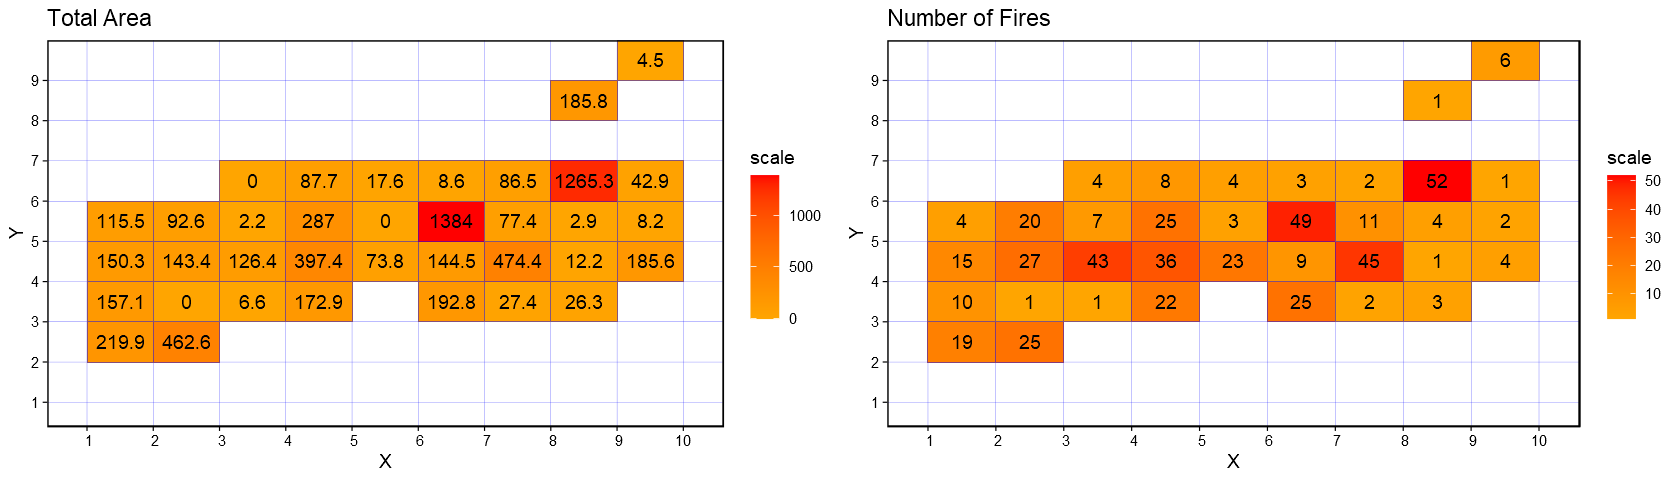

In [84]:
options(repr.plot.width=14, repr.plot.height=4) # managing the size
grid.arrange(area_plot, count_plot, nrow = 1, ncol = 2) # making the plot

A first analysis shows clearly some problematic areas. The interesection between X (6-9) and Y (4-7) accounts for more than half of fires. It will be interesting to how this areas relate to other variables.

In [85]:
temp_plot <- areaheatplot(df_spatial$temp, "Temperature")
RH_plot <- areaheatplot(df_spatial$RH, "RH")
wind_plot <- areaheatplot(df_spatial$wind, "Wind")
rain_plot <- areaheatplot(df_spatial$rain, "Rain")
FFMC_plot <- areaheatplot(df_spatial$FFMC, "FFMC")
DMC_plot <- areaheatplot(df_spatial$DMC, "DMC")
DC_plot <- areaheatplot(df_spatial$DC, "DC")
ISI_plot <- areaheatplot(df_spatial$ISI, "ISI")

options(repr.plot.width=14, repr.plot.height=15) # managing the size
grid.arrange(temp_plot, RH_plot, wind_plot, rain_plot, FFMC_plot, DMC_plot, DC_plot, ISI_plot,
             nrow = 4, ncol = 2) # making the plot

This charts are useful to explore the spatial dimension. Apparently areas with more fires also have higher proportion of the other variables. However having an X-axis and Y-axis is not practical. It would be better to create a new variable that unites both. We X ranging 1 to 9 and y ranging from 2 to 9, which means we have 72 areas. However, if we create 72 regions we are prone to overfitting our data. So we will create a dummy variable for each all the regions that concentrate more than 2% of the number of fires, which means at least n = 9 fires.

In [86]:
df_area <- data.frame(Region = 1:72, X = 1:9, Y = 2:9)
df_fires <- left_join(df_fires, df_area, by = c("X", "Y"))

In [87]:
df_spatial2 <- df_fires %>%
  group_by(Region) %>%
  summarize(Total_Area = sum(area, na.rm = TRUE),
            Count_Fires  = n())

attach(df_spatial2)
df_spatial2 <- df_spatial2[ which(Count_Fires > 10),]
detach(df_spatial2)

####  One Hot Encoding of Regions

In [88]:
danger_areas <- df_spatial2$Region 

for(i in (danger_areas)){
    df_fires[,paste0("Region", i)] <- ifelse(test = df_fires$Region == i, yes = 1, no = 0)
}

### Temporal Analysis

We will further investigate how seasonality may have an effect on the fires in Portugal. 

In [89]:
df_fires$season <- ifelse(df_fires$month == "dec" | df_fires$month == "jan" | df_fires$month == "feb",'summer', 
                          ifelse(df_fires$month == "mar" | df_fires$month == "apr" | df_fires$month == "may","autumn",
                                 ifelse(df_fires$month == "jun" | df_fires$month == "jul" | df_fires$month =="aug", "winter",
                                        ifelse(df_fires$month == "sep" | df_fires$month == "oct" | df_fires$month =='nov', "spring", 'NA'))))

In [90]:
df_fires$weekend <- ifelse(df_fires$day == "mon" | df_fires$day == "tue" | df_fires$day == "wed"| df_fires$day == "thu", 0,1)

In [91]:
df_season <- df_fires %>%
  group_by(season, day, weekend) %>%
  summarize(Total_Area = sum(logarea, na.rm = TRUE),
            Count_Fires  = n())

In [92]:
season_order <- c("summer", "autumn", "winter", "spring")
p1 <- ggplot(df_fires, aes(x= factor(season, level = season_order), y=logarea)) + geom_boxplot(fill="slateblue", alpha=0.5) + theme_classic() + ggtitle("Distribution Fires by Season")
p2 <- ggplot(df_season, aes(x= factor(season, level = season_order), y=Total_Area)) + geom_bar(fill="grey", stat="identity") + theme_classic() + ggtitle("Distribution Fires by Season")

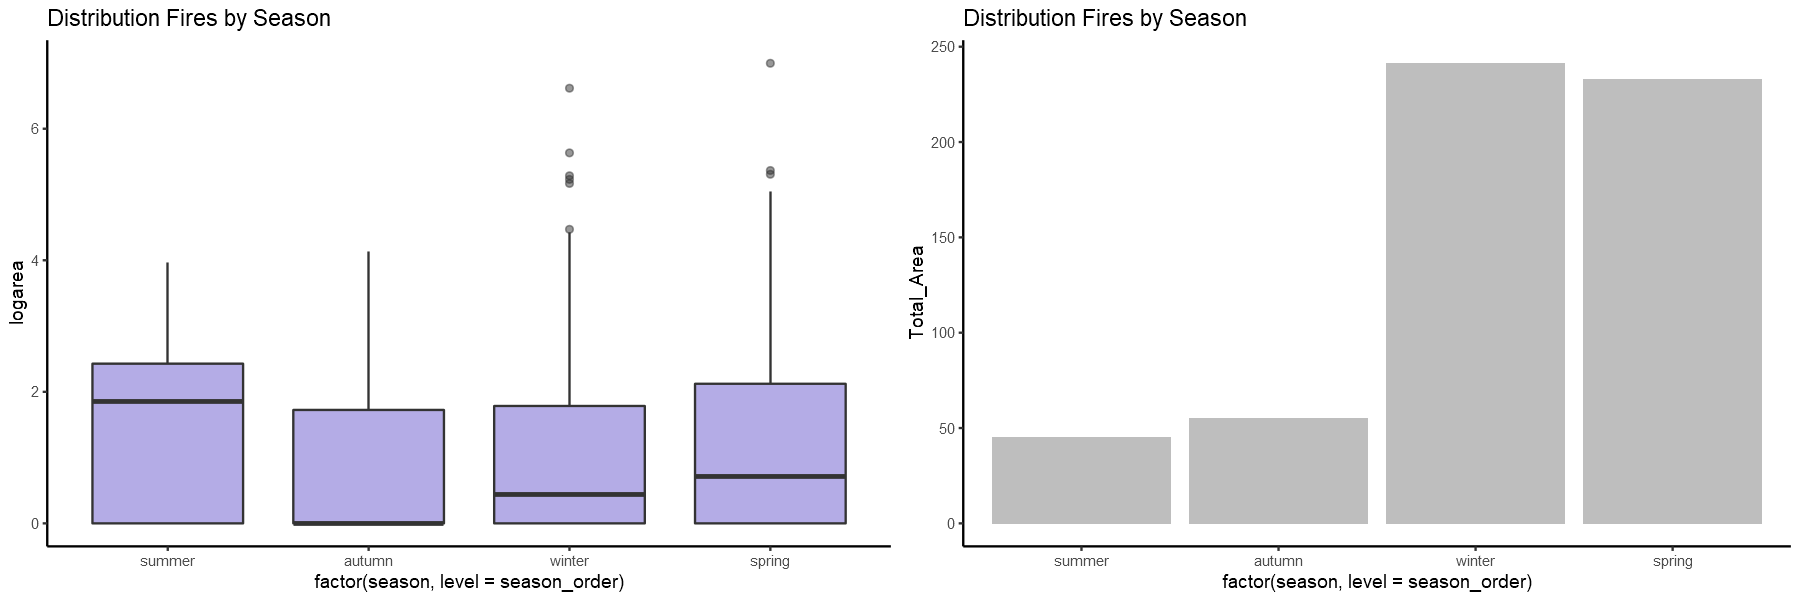

In [93]:
options(repr.plot.width=15, repr.plot.height=5) # managing the size
grid.arrange(p1, p2, nrow = 1, ncol = 2) # making the plot

Apparently due to outliers the area burned during summer was not the highest as expected, but in winter and spring. 

In [94]:
day_order <- c("mon", "tue", "wed", "thu", "fri", "sat", "sun" )

p3 <- ggplot(df_fires, aes(x= factor(day, level = day_order), y =logarea)) + geom_boxplot(fill="slateblue", alpha=0.5) + theme_classic() + ggtitle("Distribution Fires by Season")
p4 <- ggplot(df_season, aes(x= factor(day, level = day_order), y =Total_Area)) + geom_bar(fill="grey", stat="identity") + theme_classic() + ggtitle("Distribution Fires by Season")

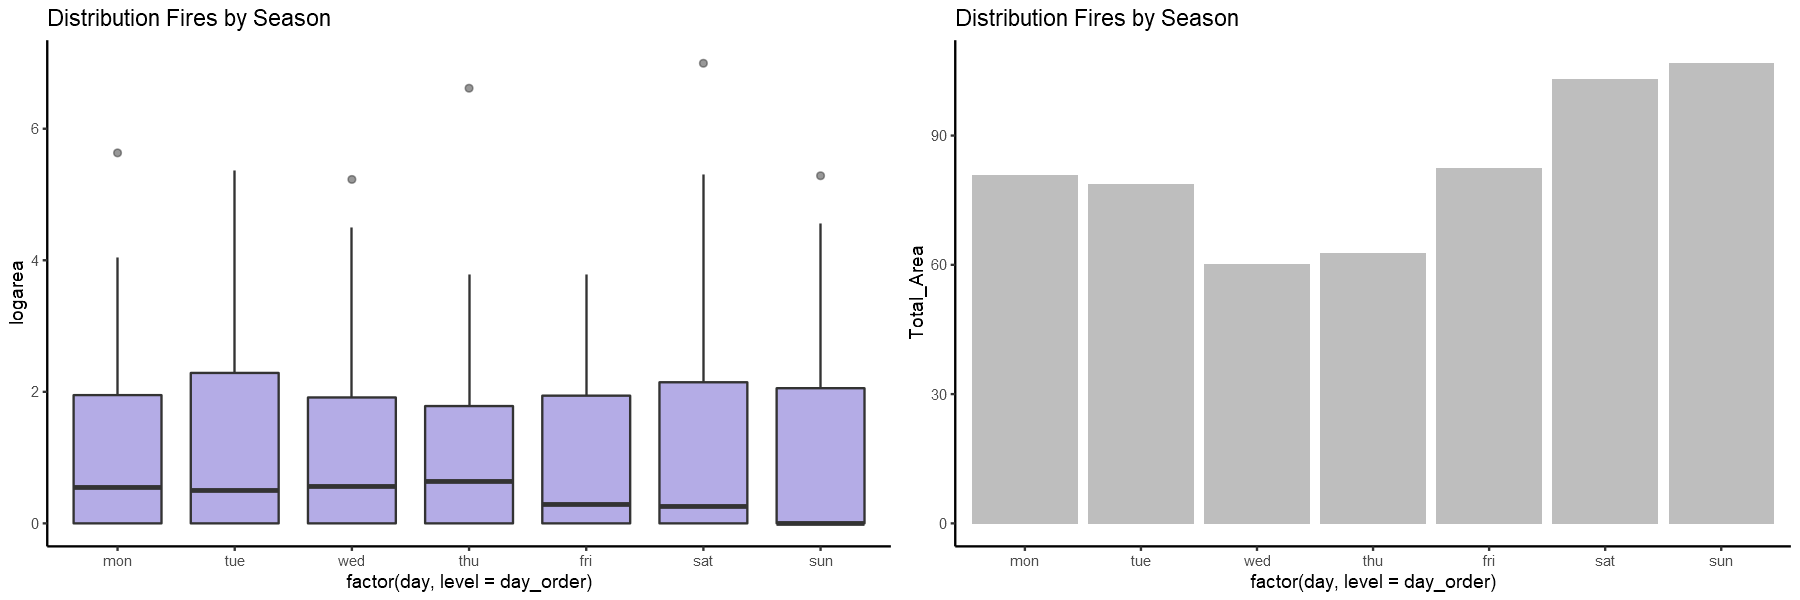

In [95]:
options(repr.plot.width=15, repr.plot.height=5) # managing the size
grid.arrange(p3, p4, nrow = 1, ncol = 2) # making the plot

In [96]:
p5 <- ggplot(df_fires, aes(x= factor(weekend), y =logarea)) + geom_boxplot(fill="slateblue", alpha=0.5) + theme_classic() + ggtitle("Distribution Fires by Weekend")
p6 <- ggplot(df_season, aes(x= factor(weekend), y =Total_Area)) + geom_bar(fill="grey", stat="identity") + theme_classic() + ggtitle("Distribution Fires by Weekend")

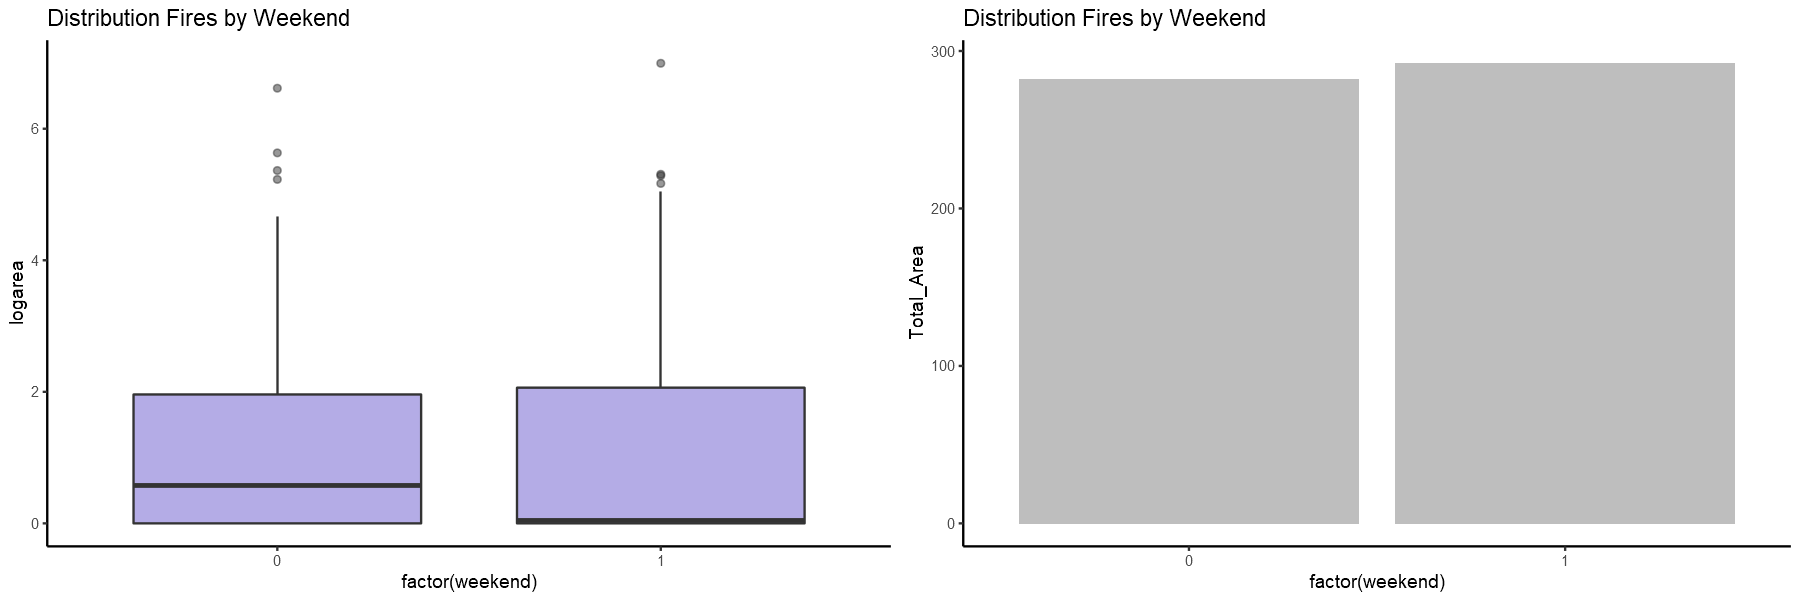

In [97]:
options(repr.plot.width=15, repr.plot.height=5) # managing the size
grid.arrange(p5, p6, nrow = 1, ncol = 2) # making the plot

In [98]:
df_fires <- df_fires[]
df_fires <- subset(df_fires, select = -c(day, month))

####  One Hot Encoding of Seasons

In [110]:
seasons <- unique(df_fires$season) 

for(i in (seasons)){
    df_fires[,paste0("season", i)] <- ifelse(test = df_fires$season == i, yes = 1, no = 0)
}

df_fires <- subset(df_fires, select = -c(season))


### A first look at correlations
Lets investigate how the variables relate to each other. To explore correlations we will leave the previously explored variables - related to temporal and and spatial analysis.

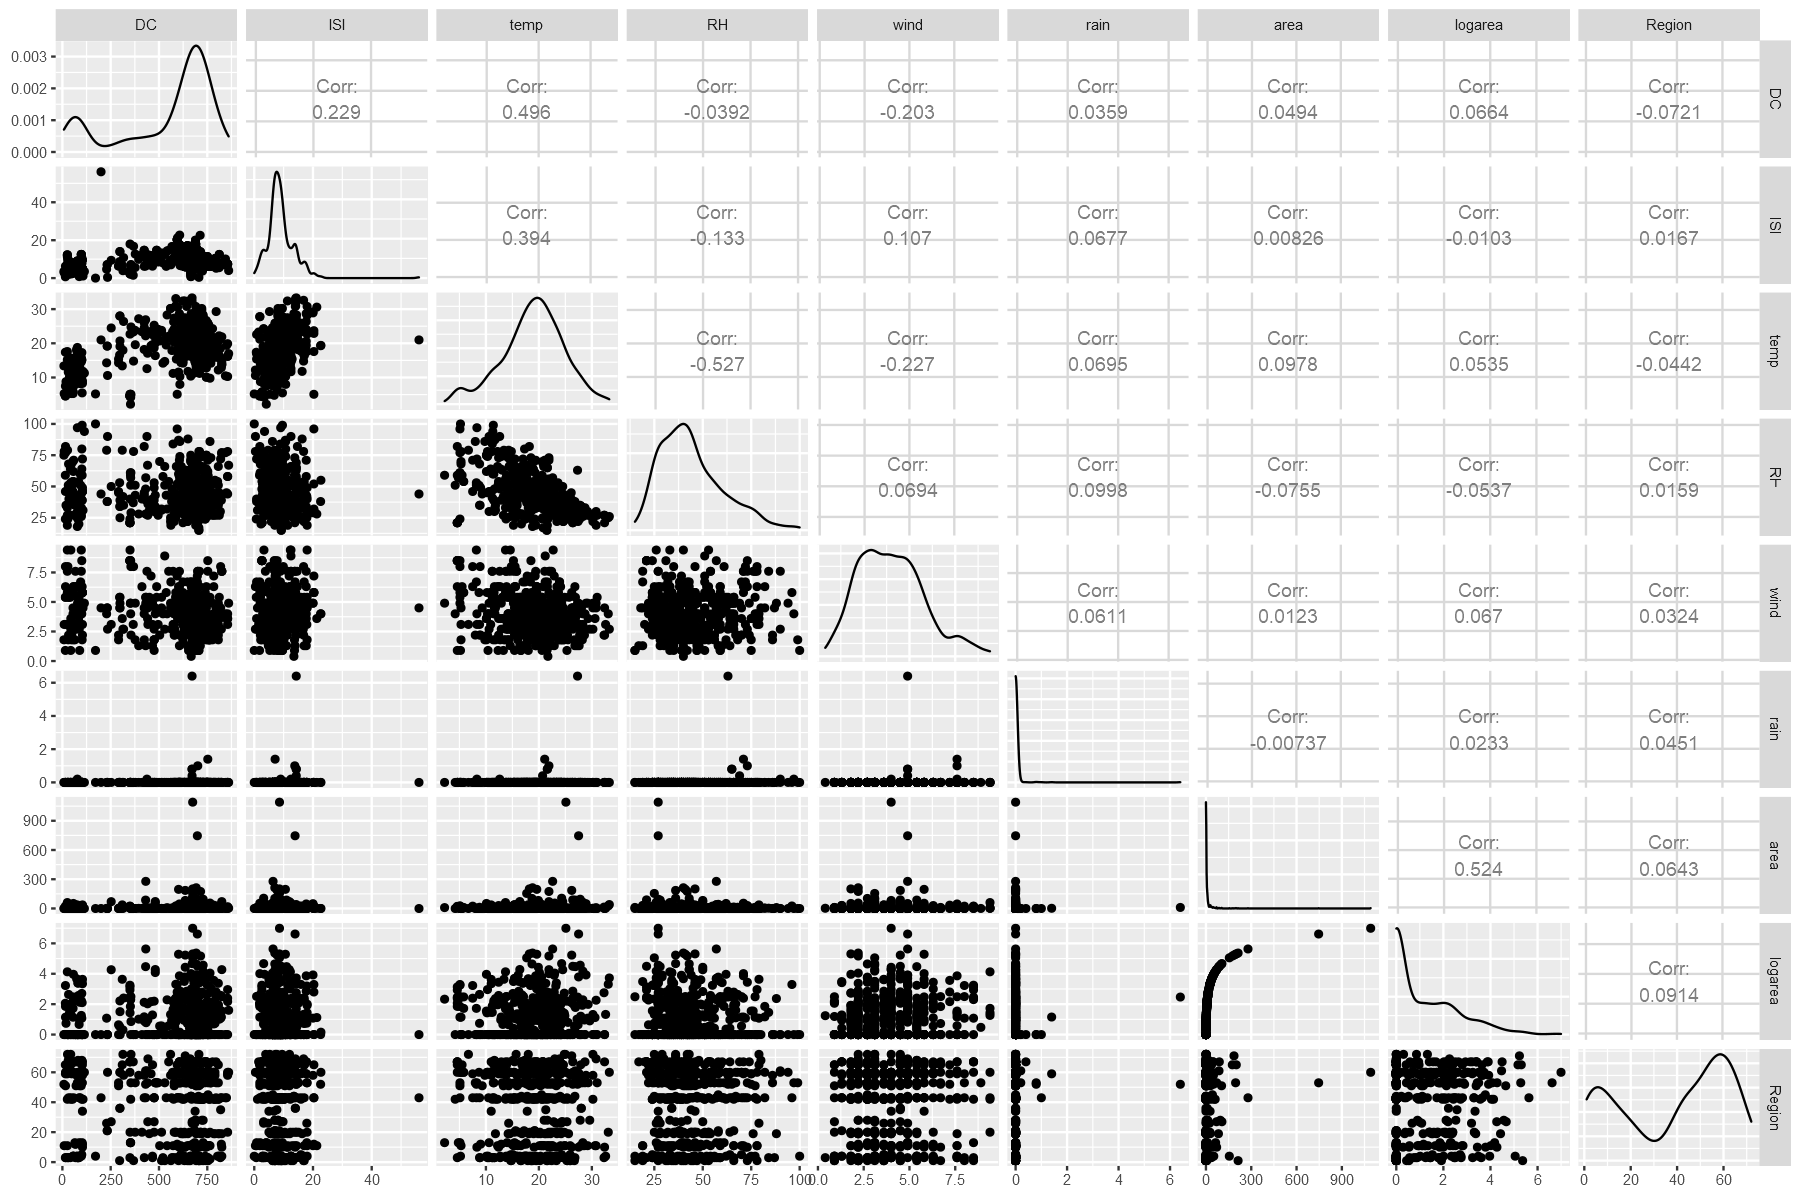

In [100]:
options(repr.plot.width=15, repr.plot.height=10) # managing the size
ggpairs(df_fires[,c(seq(5,13))])

This chart is particularly useful as other than the correlation we can see the distribution of the variables. With respect to correlation:
- RH and Temp apparently have a meaningful but small negative correlation.

### Outliers detection
Let's try using Cook’s Distance to detect these abnormal patterns.

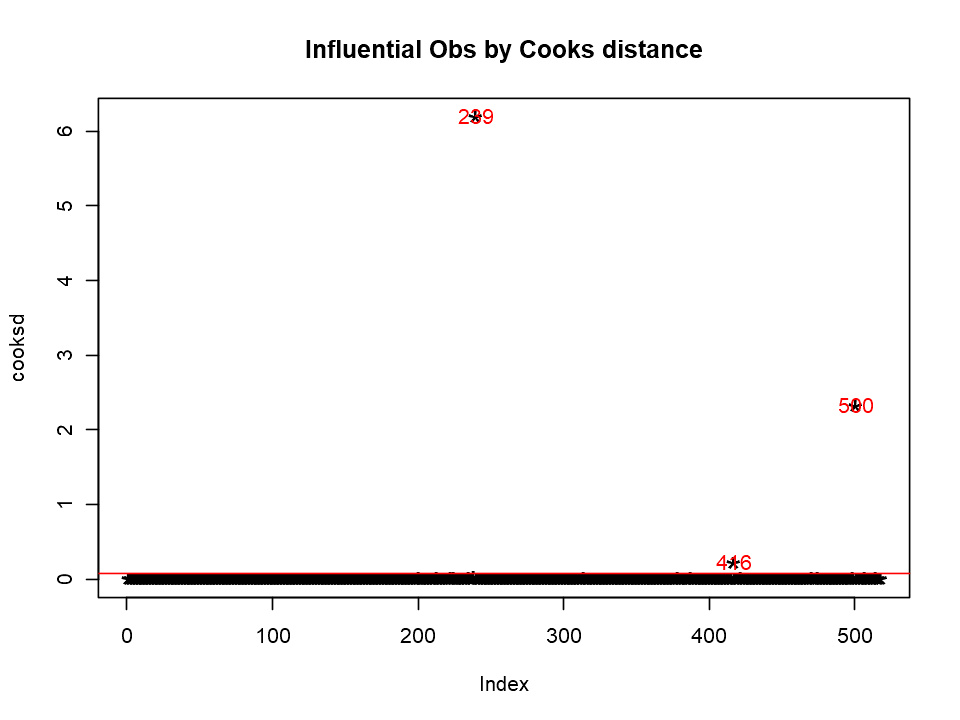

In [101]:
options(repr.plot.width=15, repr.plot.height=5) # managing the size

mod <- lm(logarea ~ ., data=df_fires[c(seq(1,12),14,15)])
cooksd <- cooks.distance(mod)

options(repr.plot.width=8, repr.plot.height=6) # managing the size
plot(cooksd, pch="*", cex=2, main="Influential Obs by Cooks distance")  # plot cook's distance
abline(h = 4*mean(cooksd, na.rm=T), col="red")  # add cutoff line
text(x=1:length(cooksd)+1, y=cooksd+0.01, labels=ifelse(cooksd>4*mean(cooksd, na.rm=T),names(cooksd),""), col="red")  # add labels

In [102]:
influential = which(cooksd>4*mean(cooksd, na.rm=T))
df_fires[influential, ]
dim(df_fires)

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,Region59,Region60,Region65,Region67,season,weekend,seasonautumn,seasonspring,seasonwinter,seasonsummer
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
239,6,5,92.5,121.1,674.4,8.6,25.1,27,4.0,0.0,...,0,1,0,0,spring,1,0,1,0,0
416,8,6,94.8,222.4,698.6,13.9,27.5,27,4.9,0.0,...,0,0,0,0,winter,0,0,0,1,0
500,7,5,96.1,181.1,671.2,14.3,27.3,63,4.9,6.4,...,0,0,0,0,winter,0,0,0,1,0


[1] 517  34

In [103]:
df_fires = df_fires[-influential, ]

## Model 1 - Linear Regression

Our first model will be a simple linear regression. <br>
We have observed that the area is not normally distributed and therefore it is preferable to predict the log of area. Nevertheless, we will also test a model to predict the area. As we know, the formula of the regression is: <br>

$ y = \beta_0 + \beta_1 * x_1 + ... + \beta_n * x_n$ 

When fitting a regression we want to obtain the best performance of our metrics. The most relevant are:
- R-Squared: Represents the proportion of the variance for a dependent variable that's explained by independent variables. The higher the better.
- Adjusted R-squared: Simillar to R-squared, but also compares the explanatory power of regression models that contain different numbers of predictors. The higher the better.
- F-Test: Indicates if the model provides a better fit to the data than a model that contains no independent variables. The higher the better.
- RMSE: Represents the standard deviation of the differences between predicted values and observed values (residuals). The lower the better.




In [104]:
# Fitting the models 
mod1 <- lm(logarea ~ ., data = subset(df_fires, select = -area)) 
mod2 <- lm(area ~ ., data = subset(df_fires, select = -logarea)) 

# summary of the model (estimates and metrics)
summary(mod1)
summary(mod2)


Call:
lm(formula = logarea ~ ., data = subset(df_fires, select = -area))

Residuals:
    Min      1Q  Median      3Q     Max 
-1.9529 -1.0008 -0.4331  0.7814  4.8688 

Coefficients: (4 not defined because of singularities)
               Estimate Std. Error t value Pr(>|t|)   
(Intercept)  -8.488e-01  1.513e+00  -0.561  0.57504   
X             1.155e-01  7.091e-02   1.629  0.10391   
Y            -2.258e-01  1.052e-01  -2.146  0.03234 * 
FFMC          1.854e-02  1.457e-02   1.272  0.20383   
DMC           1.882e-03  1.650e-03   1.141  0.25462   
DC            1.979e-04  7.414e-04   0.267  0.78963   
ISI          -1.402e-02  1.690e-02  -0.829  0.40725   
temp          2.386e-02  2.062e-02   1.157  0.24780   
RH            9.610e-04  5.711e-03   0.168  0.86645   
wind          8.578e-02  3.612e-02   2.374  0.01796 * 
rain         -9.400e-01  6.756e-01  -1.391  0.16479   
Region        7.445e-05  8.750e-03   0.009  0.99322   
Region1      -1.011e+00  4.696e-01  -2.154  0.03175 * 
Region


Call:
lm(formula = area ~ ., data = subset(df_fires, select = -logarea))

Residuals:
    Min      1Q  Median      3Q     Max 
-24.532 -11.204  -5.270   0.483 263.486 

Coefficients: (4 not defined because of singularities)
               Estimate Std. Error t value Pr(>|t|)  
(Intercept)  -15.319053  31.153385  -0.492   0.6231  
X              1.147176   1.460170   0.786   0.4325  
Y             -0.825501   2.166687  -0.381   0.7034  
FFMC           0.141668   0.300081   0.472   0.6371  
DMC            0.060338   0.033983   1.776   0.0764 .
DC            -0.022466   0.015267  -1.472   0.1418  
ISI           -0.548722   0.348075  -1.576   0.1156  
temp           0.476564   0.424595   1.122   0.2623  
RH             0.005785   0.117606   0.049   0.9608  
wind           1.013500   0.743865   1.362   0.1737  
rain          -9.061857  13.912340  -0.651   0.5151  
Region         0.075843   0.180183   0.421   0.6740  
Region1        3.281061   9.670037   0.339   0.7345  
Region3       -5.611

As expected `mod1` performed better, because logarea is more appropriate as a label. Therefore we will be working exclusevely with mod1. It calls our attention that the model has a small predictive power with respect to the metrics of performance, such as F-statistic and R-squared. Let's proceed with diagnostic plots.

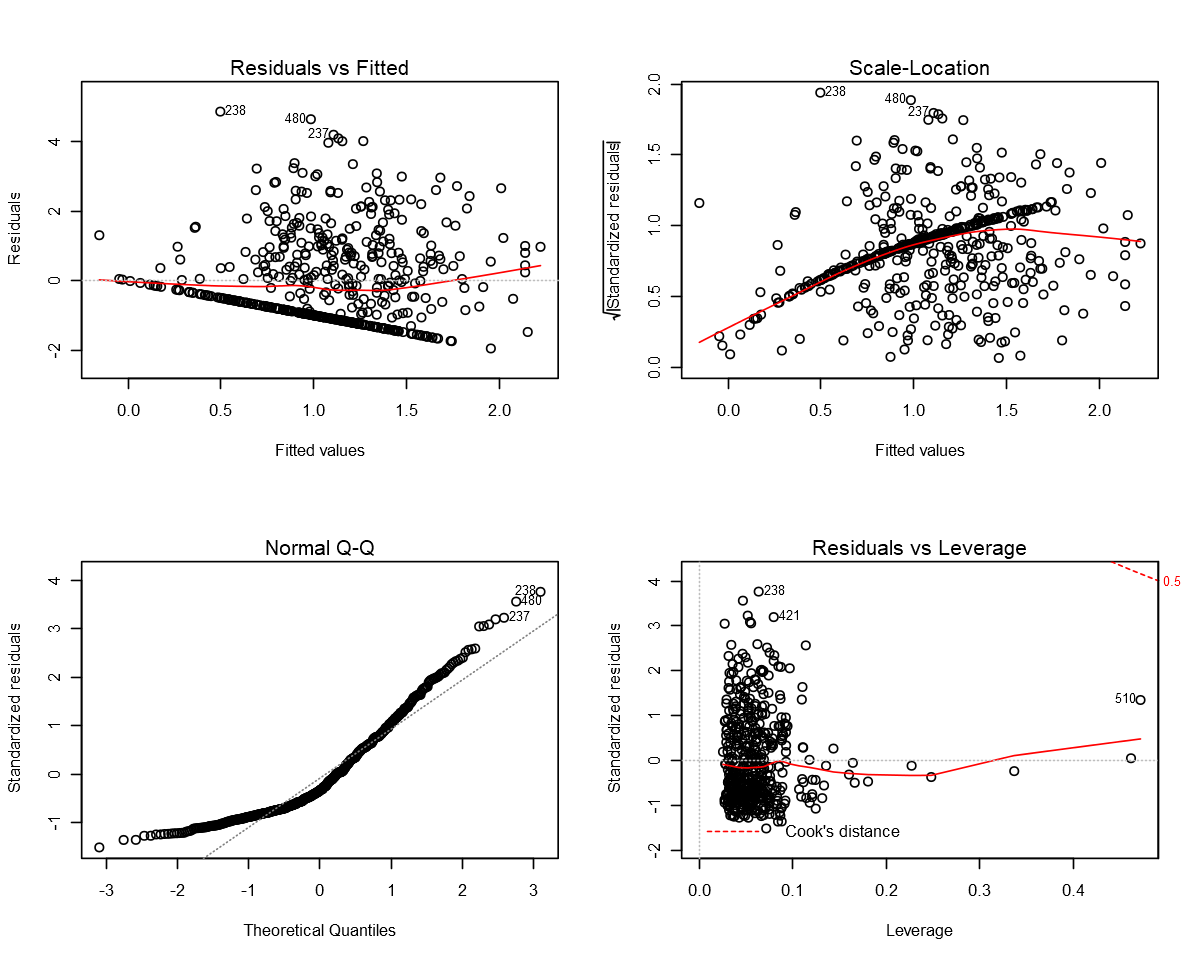

In [105]:
options(repr.plot.width=10, repr.plot.height=8) # managing the size
par(mfcol=c(2,2))
plot(mod1)

The diagnostic plots show residuals in four different ways. Some observations about the plots:

- **Residual vs fitted plot and scale-location plot:**  They access if the residuals have non-linear patterns and if residuals are spread equally along the ranges of predictors. We can see an abnormal pattern such as some points in a linear trend. Other points are well behaved.
- **Q-Q plot:** Unfortunately we can observe that the distribution of the residuals is not normal and this might explain the performance of our model. 
- **residual-leverage plot**: Since we have previously performed data manipulation removing outliers and highly influential points, they are not a concern in this step.


### Subset Selection

In this task, we will use the regsubsets() function to perform best subset selection in order to choose the best model containing the predictors. We want the best model obtained according to $C_p$, $BIC$, and adjusted $R^2$. Show some plots to provide evidence for your answer, and report the coefficients of the best model obtained.

In [106]:
regfit.full <- regsubsets(logarea ~ ., data = subset(df_fires, select = -area), nvmax = 30)
reg.summary <- summary(regfit.full)
reg.summary

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"4  linear dependencies found"


Subset selection object
Call: regsubsets.formula(logarea ~ ., data = subset(df_fires, select = -area), 
    nvmax = 30)
34 Variables  (and intercept)
             Forced in Forced out
X                FALSE      FALSE
Y                FALSE      FALSE
FFMC             FALSE      FALSE
DMC              FALSE      FALSE
DC               FALSE      FALSE
ISI              FALSE      FALSE
temp             FALSE      FALSE
RH               FALSE      FALSE
wind             FALSE      FALSE
rain             FALSE      FALSE
Region           FALSE      FALSE
Region1          FALSE      FALSE
Region3          FALSE      FALSE
Region4          FALSE      FALSE
Region11         FALSE      FALSE
Region19         FALSE      FALSE
Region20         FALSE      FALSE
Region42         FALSE      FALSE
Region43         FALSE      FALSE
Region52         FALSE      FALSE
Region53         FALSE      FALSE
Region58         FALSE      FALSE
Region59         FALSE      FALSE
Region60         FALSE      FALSE


Due to the fact we have created many dummy variables for geographic region, our model may have up to 30 variables. We have found the best subset for n variables, when n ranges from 1 to 30. Now we will plot the number of variables from the best models against the accuracy indicators such as Cp, BIC, Ajusted R-squared and RSS..

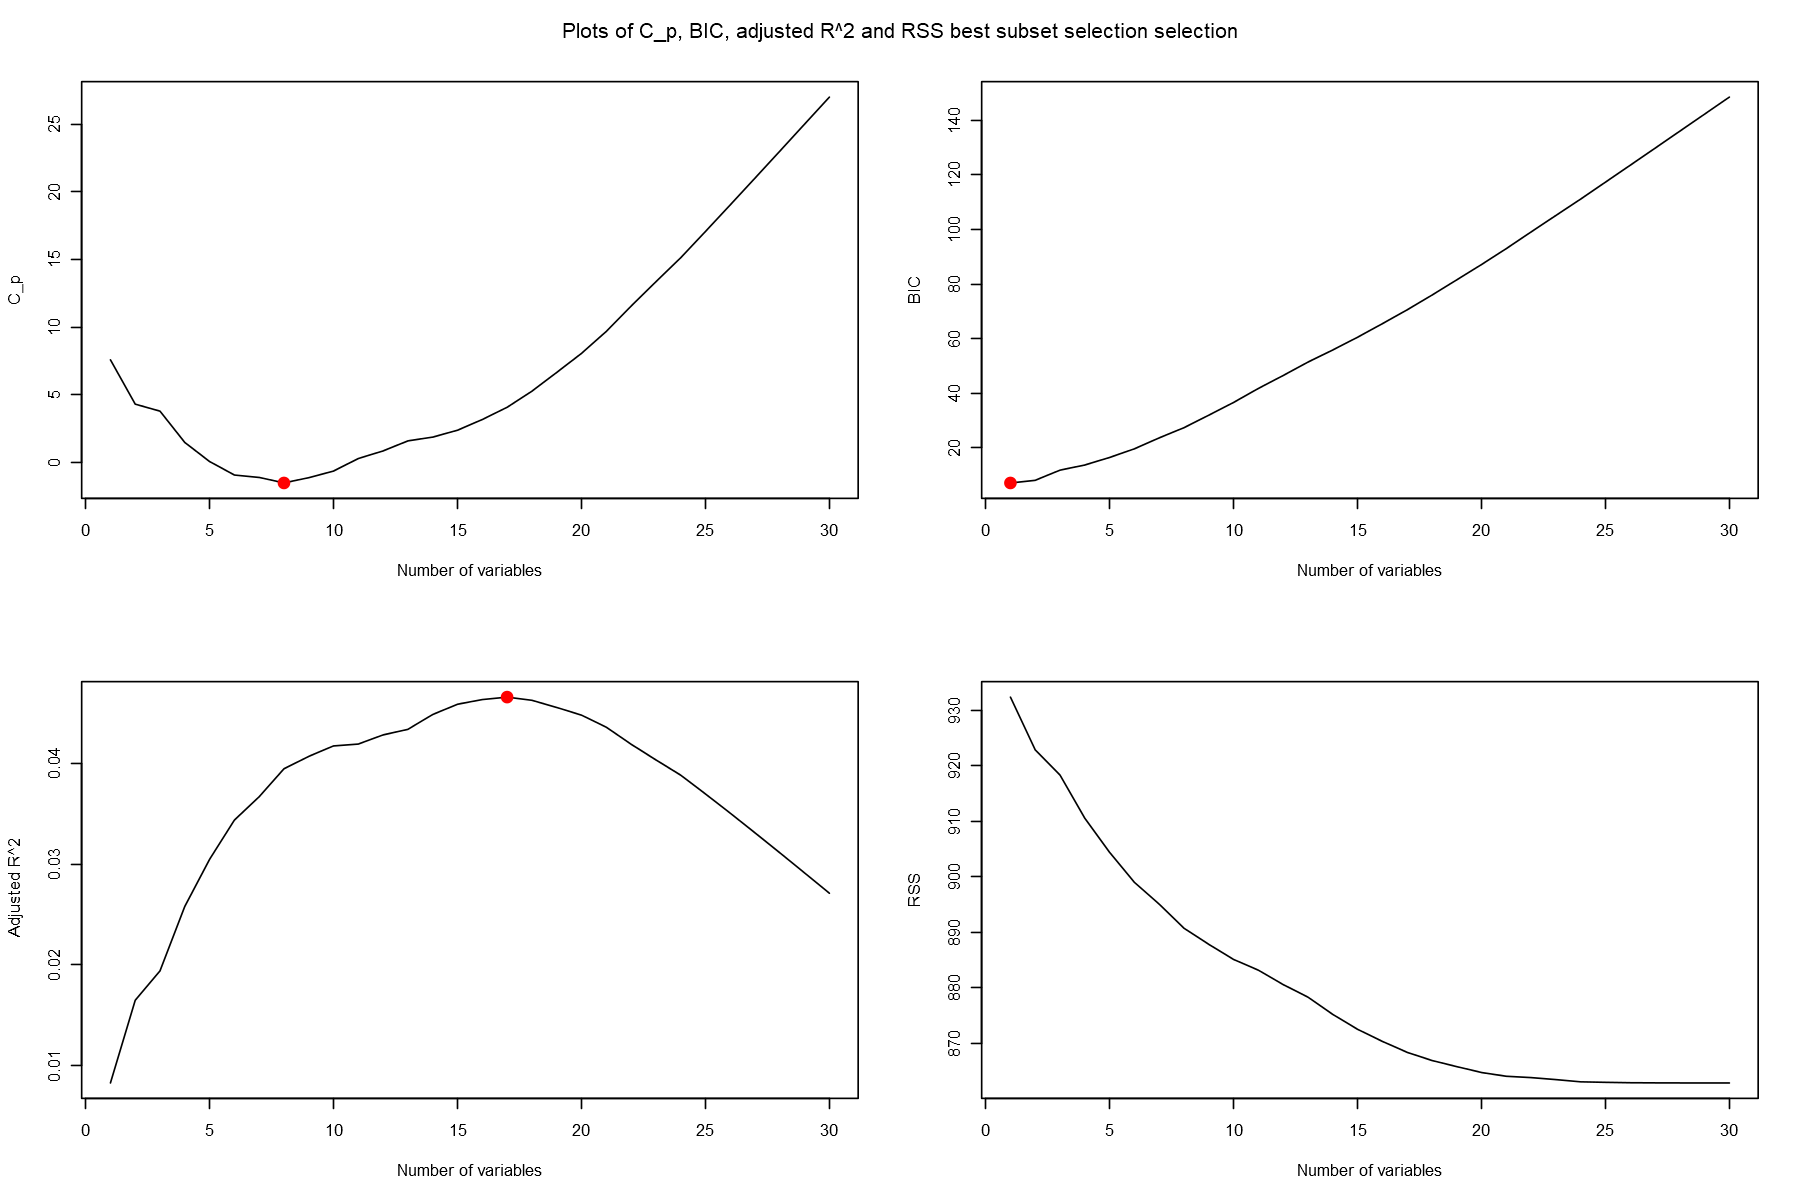

In [107]:
options(repr.plot.width=15, repr.plot.height=10) # managing the size
par(mfrow = c(2, 2))
plot(reg.summary$cp, xlab = "Number of variables", ylab = "C_p", type = "l")
points(which.min(reg.summary$cp), reg.summary$cp[which.min(reg.summary$cp)], col = "red", cex = 2, pch = 20)
plot(reg.summary$bic, xlab = "Number of variables", ylab = "BIC", type = "l")
points(which.min(reg.summary$bic), reg.summary$bic[which.min(reg.summary$bic)], col = "red", cex = 2, pch = 20)
plot(reg.summary$adjr2, xlab = "Number of variables", ylab = "Adjusted R^2", type = "l")
points(which.max(reg.summary$adjr2), reg.summary$adjr2[which.max(reg.summary$adjr2)], col = "red", cex = 2, pch = 20)
plot(reg.summary$rss, xlab = "Number of variables", ylab = "RSS", type = "l")
mtext("Plots of C_p, BIC, adjusted R^2 and RSS best subset selection selection", side = 3, line = -2, outer = TRUE)

It is interesting the fact that we have found different models according to each indicator. Lets compare then.

In [108]:
coef(regfit.full, which.min(reg.summary$cp))
coef(regfit.full, which.min(reg.summary$bic))
coef(regfit.full, which.max(reg.summary$adjr2))

(Intercept)          DMC         temp         wind         rain      Region1 
 0.182500047  0.002489168  0.025512544  0.078994651 -1.079230757 -0.683646735 
     Region3 seasonwinter seasonsummer 
-0.515570481 -0.296270667  0.703749945

(Intercept)     Region3 
  1.1276086  -0.4947053

(Intercept)            X            Y         FFMC          DMC          ISI 
-0.997104851  0.068147262 -0.171890735  0.020200308  0.001798358 -0.017217233 
        temp         wind         rain      Region1      Region3     Region42 
 0.018378327  0.089035938 -0.924201914 -1.015008027 -0.613997479 -0.804676318 
    Region43     Region52     Region59     Region65 seasonsummer seasonspring 
-0.471957645 -0.570260609 -0.582958467 -0.426915184  0.956525561  0.286695402

The $C_P$ model seems to be the one less prone to overfitting the data. It uses 8 variables wich are apparently relevant. Therefore it will be our chosen model. We will now analyse the improvment of this model against our initial model.  

In [109]:
mod3 <- lm(logarea ~ ., data = subset(df_fires, select = c(DMC, temp, wind, rain, Region1, Region3, season, seasonwinter)))

ERROR: Error in eval(predvars, data, env): object 'logarea' not found


## Second Model

In [245]:
df_fires$b_area <- ifelse(df_fires$area == 0, 0, 1)
head(df_fires)
dim(df_fires)

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,Region52,Region53,Region58,Region59,Region60,Region65,Region67,season,weekend,b_area
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,1,0,0,0,0,0,0,autumn,1,0
2,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,spring,0,0
3,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,spring,1,0
4,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,1,0,0,0,0,0,autumn,1,0
5,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,1,0,0,0,0,0,autumn,1,0
6,8,6,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,...,0,1,0,0,0,0,0,winter,1,0


[1] 514  31

In [55]:
set.seed(200)
shuffled <- df_fires[sample(510),]

In [56]:
train_data <- shuffled[1:round(0.85 * 510),]
test_data <- shuffled[(round(0.85 * 510) + 1):510,]

In [57]:
write.csv(train_data, file = "train_data.csv")
write.csv(test_data, file = "test_data.csv")

In [58]:
xvars <- c("X", "Y", "month", "day", "FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind", "rain")

In [59]:
Fm <- function(y, xvars){
  return(as.formula(paste(y, "~", paste(xvars, collapse = "+"))))
}

# part 1
logistic.fit <- glm(Fm("b_area", xvars), train_data, family = binomial)

In [126]:
phat <- predict(logistic.fit, test_data, type = "response")
prediction <- phat > 0.5
test_data$prediction <- prediction
c_area <- test_data$b_area == 1
test_data$c_area <- c_area

In [127]:
confusionMatrix(as.factor(prediction), as.factor(c_area))

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE    15   10
     TRUE     21   30
                                          
               Accuracy : 0.5921          
                 95% CI : (0.4733, 0.7035)
    No Information Rate : 0.5263          
    P-Value [Acc > NIR] : 0.15057         
                                          
                  Kappa : 0.1693          
                                          
 Mcnemar's Test P-Value : 0.07249         
                                          
            Sensitivity : 0.4167          
            Specificity : 0.7500          
         Pos Pred Value : 0.6000          
         Neg Pred Value : 0.5882          
             Prevalence : 0.4737          
         Detection Rate : 0.1974          
   Detection Prevalence : 0.3289          
      Balanced Accuracy : 0.5833          
                                          
       'Positive' Class : FALSE           
                     

In [ ]:
# part 2
ols.fit <- lm(Fm("area", xvars), train_data[train_data$area > 0,])
logols.fit <- lm(Fm("logarea", xvars), train_data[train_data$area > 0,])
gamma.fit <- glm(Fm("area", xvars), train_data[train_data$area > 0,], family = Gamma(link = log))

Using these models we can predict mean burned area, Y, given a matrix of covariates, X, as follows,

E[Y|X]=Pr(Y>0|X)×E(Y|Y>0,X). The first term can be easily estimated using a logistic regression. The second term is easy to estimate if the expected value of Y is being modeled directly. For instance, in a gamma GLM with a log link, we model the log of mean burned area,

log(E[Y])=Xβ, where β is the coefficient vector and we have suppressed the dependence of E[Y] on X. We can therefore obtain the mean of burned area by simply exponentiating log(E[Y]). Things are less straightforward in the logtransformed OLS regression since we are modeling the mean of log burned area, E[log(Y)]=Xβ, and E[exp(log(Y))]≠exp(E[log(Y)]). We can however estimate mean burned area if the error term, ϵ=logY−Xβ, is normally distributed with a constant variance (i.e. homoskedastic), σ2. Then, using the properties of the lognormal distribution, E[Y|Y>0]=exp(Xβ+σ2/2). With this in mind, burned area can be predicted as follows.

In [61]:
phat <- predict(logistic.fit, test_data, type = "response")
pred <- as.data.frame(test_data[,'area'],colname = 'area')
colnames(pred)[1] <- "area"
pred$ols <- phat * predict(ols.fit, test_data)
pred$logols <- phat * exp(predict(logols.fit, test_data) + summary(logols.fit)$sigma^2/2)
pred$gamma <- phat * predict(gamma.fit, test_data, type = "response")

Let's assess model fit using the root mean square error (RMSE). THE RMSE is just the square root of the mean square error (MPE), which has a nice interpretation because it can decomposed into the sum of the variance and squared bias of the prediction.



In [62]:
RMSE <- function(x, y)  sqrt(mean((y - x)^2, na.rm = TRUE))
rmse <- c(RMSE(pred$area, pred$ols),
          RMSE(pred$area, pred$logols),
          RMSE(pred$area, pred$gamma))
names(rmse) <- c("OLS", "Log OLS", "Gamma")
print(rmse)

     OLS  Log OLS    Gamma 
23.07174 22.02166 22.76969 


Predictions from the gamma model, the OLS regression in levels, and the log OLS regression are very similar.



#### Predictive Simulation
Let's try to simulate to compare predictions from themodels to observed data.

We will consider three two-part models for burned area: a logistic-normal model, a logistic-lognormal model and a logistic-gamma model. For the normal and lognormal models we will assume that the error term is constant across individuals. Both the lognormal and gamma distributions have the desirable property that the variance is proportional to square of the mean.

In [63]:
# simulating data from the logistic-normal model
n <- nrow(test_data)
d <- rbinom(n, 1, phat)
y.norm <- d * rnorm(n, pred$ols, summary(ols.fit)$sigma)

In [64]:
# simulation for the logistic-lognormal model
y.lognorm <- d * rlnorm(n, predict(logols.fit, test_data) , summary(logols.fit)$sigma)

Simulating data from a gamma distribution. estimating a shape parameter, ai, and rate parameter bi, for each observation. Assum the shape parameter is constant across observations. E(Yi)=μi=a/bi. R uses methods of moments to estimate the dispersion parameter—which is the inverse of the shape parameter—in a gamma GLM. Programmatically, it divides the sum of the squared ‘working’ residuals by the number of degrees of freedom in the model.

In [65]:
res <- (gamma.fit$model$area - gamma.fit$fit)/gamma.fit$fit # this is equivalent to gamma.fit$res
c(sum(res^2)/gamma.fit$df.res, summary(gamma.fit)$dispersion)

[1] 2.570724 2.570724

In [66]:
# use MASS package gamma.shape to estimate the shape parameter (this method uses maximum likelihood).
a <- gamma.shape(gamma.fit)$alpha
b <- a/pred$gamma
y.gamma <- d * rgamma(n, shape = a , rate = b)
# a = 0.6962517

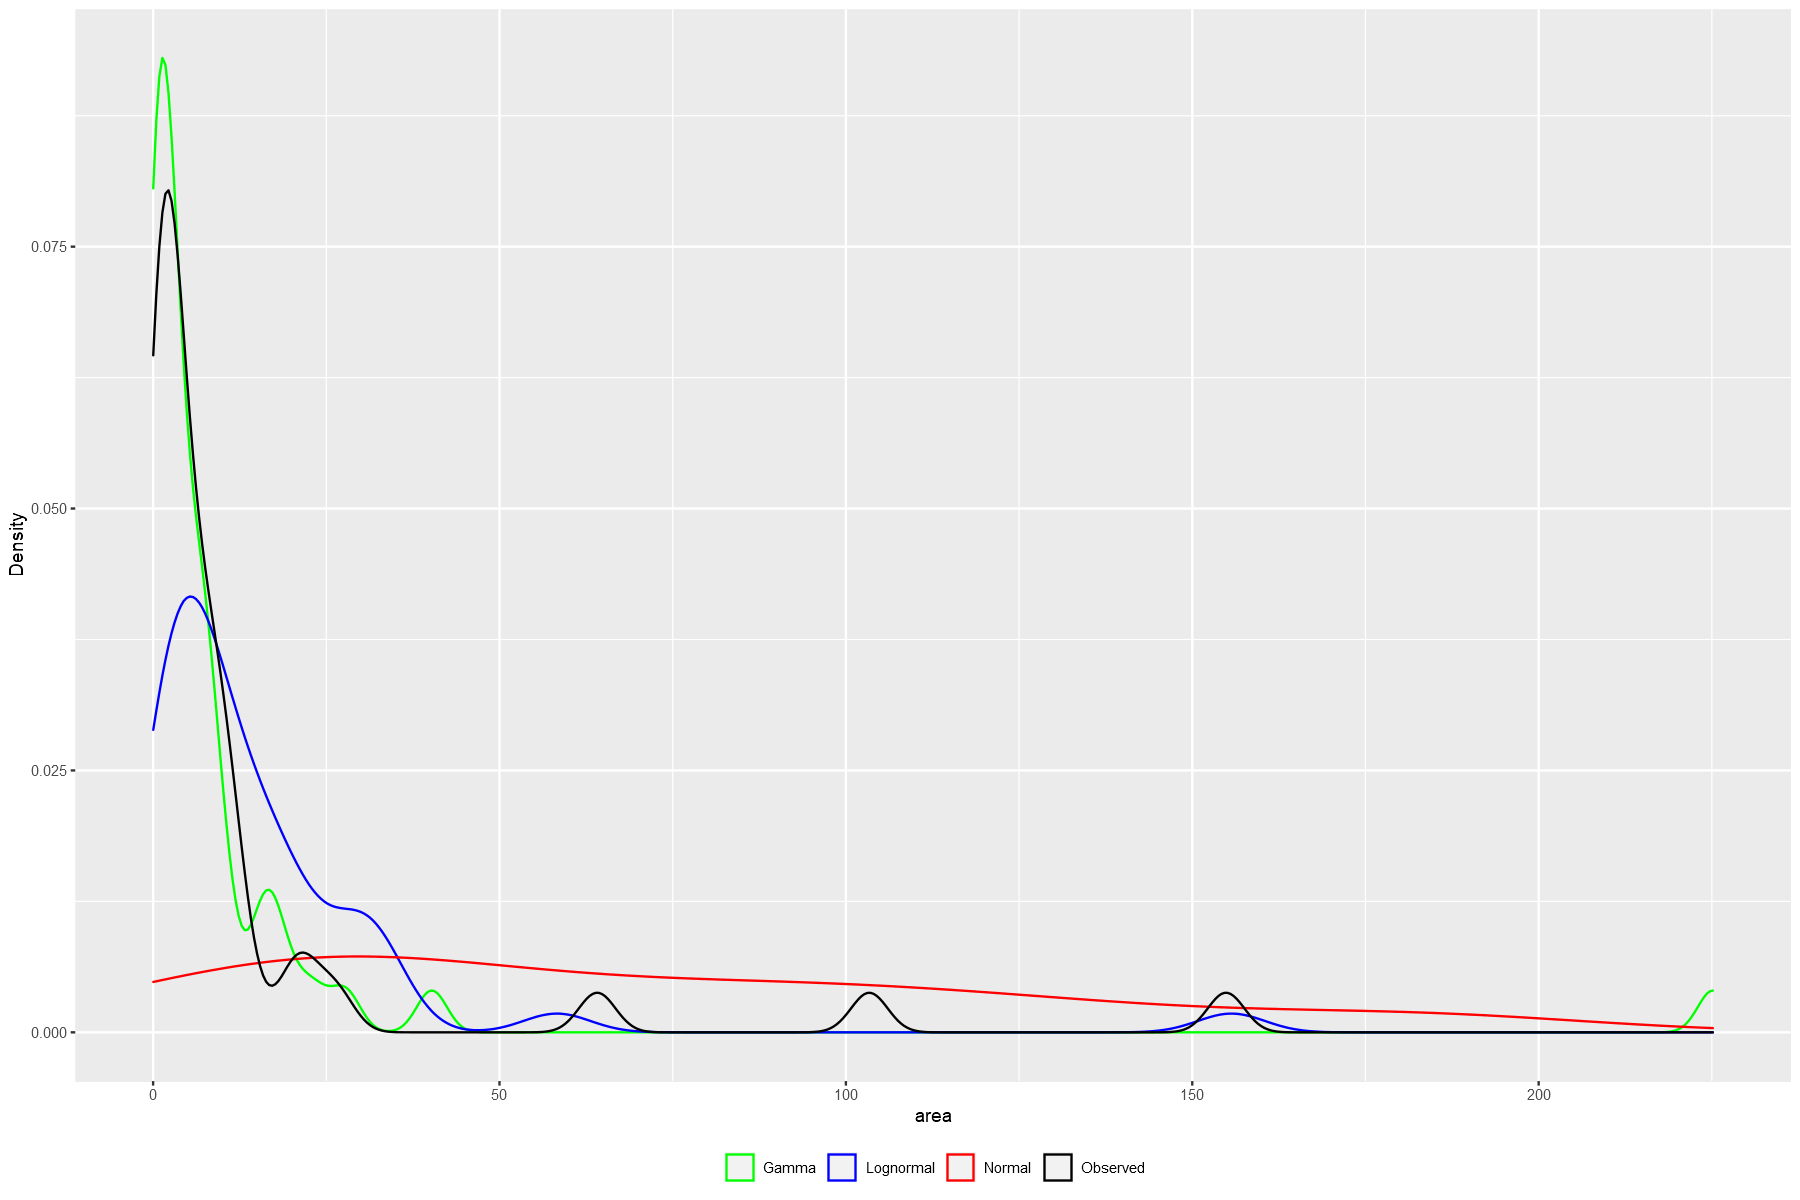

In [67]:
y <- pred$area
p.dat <- data.table(y = c(y, y.norm, y.lognorm, y.gamma),
                    lab = c(rep("Observed", n), rep("Normal", n), 
                            rep("Lognormal", n), rep("Gamma", n)))

p <- ggplot(p.dat[y > 0 & y < 10000], aes(x = y, col = lab)) + 
  geom_density(kernel = "gaussian") +
  xlab("area") + ylab("Density") +
  theme(legend.position="bottom") + labs(col = "") +
  scale_color_manual(values=c(Observed = "black", Normal = "red", 
                              Lognormal = "blue", Gamma = "green")) 
print(p)

As expected, the logistic-normal model performs horribly since non-negative burned area are highly right skewed. The logistic-normal model also allows for negative burned area which is clearly undesirable since burned area cannot be negative. The logistic-gamma and logistic-lognormal models both fit the data pretty well although the lognormal model seems to predict the distribution of burned area slightly better.

## KNN Regression


In [76]:
# KNN function
knn <- function(train_data, train_label, test_data, K=3){

    test_label <- c()
    
    ## count number of train and test samples
    train_len <- nrow(train_data)
    test_len <- nrow(test_data)
    
    ## calculate distances between samples
    dist <- as.matrix(dist(rbind(test_data, train_data), method= 'manhattan'))[1:test_len, (test_len+1):(test_len+train_len)]
    
    ## for each test sample...
    for (i in 1:test_len){
        
        ### ...find its K nearest neighbours from training sampels...
        nn <- as.data.frame(sort(dist[i,], index.return = TRUE))[1:K,2]
        
        ###
        test_label[i]<- sum(train_label[nn])/K
    }
    
    ## return 
    return (round(test_label,3))
}

In [80]:
sqrt(mean((test_data[,'area'] - knn(train_data[ , xvars], train_data[,'area'], test_data[ , xvars],K =2))^2, na.rm = TRUE))

Warning message in dist(rbind(test_data, train_data), method = "manhattan"):
"NAs introduced by coercion"


[1] 67.95316

### Random Forest

In [77]:
# install.packages('rsample')
# install.packages('randomForest')
# install.packages('ranger')
# install.packages('caret')
# install.packages('h2o')

In [76]:
library('rsample')      # data splitting 
library('randomForest') # basic implementation
library('ranger')       # a faster implementation of randomForest
library('caret')        # an aggregator package for performing many machine learning models
library('h2o')          # an extremely fast java-based platform

In [74]:
# for reproduciblity
set.seed(123)

# default RF model
m1 <- randomForest(
  formula = logarea ~ .,
  data    = df_fires
)

In [73]:
df_fires$season <- as.factor(df_fires$season)

In [75]:
predict(m1, test_data)

ERROR: Error in predict.randomForest(m1, test_data): Type of predictors in new data do not match that of the training data.
